# Projected density of states (PDOS)
For the source code, see [pdos](https://workgraph-collections.readthedocs.io/en/latest/ase/espresso/module.html#workgraph_collections.ase.espresso.pdos.pdos_workgraph).


## Visualizing the WorkGraph Builder



In [5]:
from workgraph_collections.ase.espresso.pdos import pdos_workgraph
from aiida import load_profile
load_profile()

task = pdos_workgraph.task()
task.to_html()

## Visualizing the WorkGraph

In [6]:
from workgraph_collections.ase.espresso.pdos import pdos_workgraph

wg = pdos_workgraph(run_relax=True, run_scf=True)
wg.to_html()

## Example: Silicon

### Prepare the inputs and submit the workflow


In [7]:
from ase.build import bulk
from aiida import load_profile
from copy import deepcopy

from workgraph_collections.ase.espresso.pdos import pdos_workgraph

load_profile()

atoms = bulk('Al')


metadata = {
    "options": {
        'prepend_text' : """eval "$(conda shell.posix hook)"
        conda activate aiida
        export OMP_NUM_THREADS=1
        """,
    }
}
pseudopotentials = {"Al": "Al.pbe-n-rrkjus_psl.1.0.0.UPF"}
# pseudo_dir = "/home/xing/data/ase/espresso_pseudo"
pseudo_dir = "/home/wang_x3/datas/pseudos/psl"
scf_input_data = {
    "system": {"ecutwfc": 30, "ecutrho": 240,
               "occupations": "smearing",
                "degauss": 0.01,
                "smearing": "gaussian",
                },
}
nscf_input_data = deepcopy(scf_input_data)
nscf_input_data["system"].update({"occupations": "tetrahedra"})
inputs = {
    "scf": {
        "input_data": scf_input_data,
        "kpts": (15, 15, 15),
        "computer": "localhost",
        "metadata": metadata
    },
    "nscf": {
        "input_data": nscf_input_data,
        "kpts": (30, 30, 30),
        "computer": "localhost",
        "metadata": metadata
    },
    "dos": {
        "input_data": {},
        "computer": "localhost",
        "metadata": metadata
    }
}
#------------------------- Set the inputs -------------------------
wg = pdos_workgraph(atoms=atoms,
                    pw_command="mpirun -np 4 pw.x",
                    dos_command="mpirun -np 4 dos.x",
                    projwfc_command="mpirun -np 4 projwfc.x",
                    pseudopotentials=pseudopotentials,
                    pseudo_dir=pseudo_dir,
                    inputs=inputs)
#------------------------- Submit the calculation -------------------
# wg.run()
wg.submit(wait=True, timeout=200)



WorkGraph process created, PK: 21983


<WorkChainNode: uuid: d6e5867f-31a0-44f1-b715-3a90a3baa534 (pk: 21983) (aiida_workgraph.engine.workgraph.WorkGraphEngine)>

## Print the results

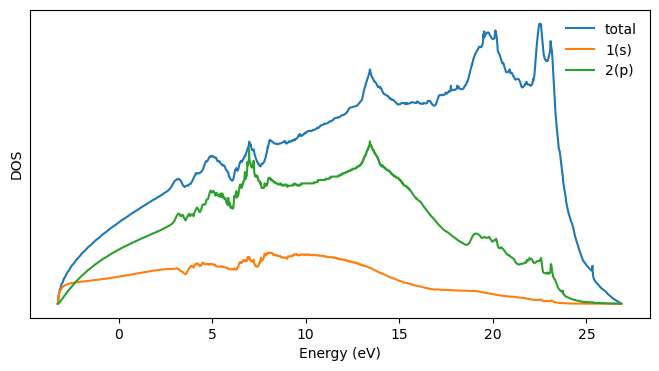

In [31]:
import matplotlib.pyplot as plt
import numpy as np

#------------------------- Print the output -------------------------
dos_data = wg.tasks['dos'].outputs["results"].value.value
pdos_data = wg.tasks['projwfc'].outputs["results"].value.value
# make plots
plt.figure(figsize = (8, 4))
plt.plot(dos_data['dos_energy'], dos_data['dos'], label='total')
# plt.plot(pdos_data['totol']['energy'], pdos_data['totol']['dos'], label='total')
for file_name, data in pdos_data['atom'].items():
        value = np.array(data)
        plt.plot(value[:, 0], np.sum(value[:, 2:], axis=1), label=file_name[-4:])
plt.yticks([])
plt.xlabel('Energy (eV)')
plt.ylabel('DOS')
plt.legend(frameon=False)
